## Inicialización

La cadena de supermercados Good Seed me ha encomendado la tarea de explorar cómo la ciencia de los datos puede ayudarles a cumplir con las leyes sobre la venta de alcohol a personas menores de edad. Para abordar este desafío, se dispone de cámaras en el área de pago de las tiendas que se activan cuando alguien está comprando alcohol. La idea es utilizar técnicas de visión artificial para determinar la edad de las personas a partir de las fotos capturadas.

Mi objetivo principal es construir y evaluar un modelo que pueda verificar automáticamente la edad de las personas en las imágenes. Para lograrlo, se cuenta con un conjunto de fotografías de personas acompañadas de sus edades.

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Rutas a los directorios
labels_file = '/datasets/faces/labels.csv'
data_dir = '/datasets/faces/final_files/'

## EDA

In [3]:
#Cargar el archivo de etiquetas
labels_df = pd.read_csv(labels_file)

#Seleccionar edades únicas
unique_ages = labels_df['real_age'].unique()

unique_ages

array([  4,  18,  80,  50,  17,  27,  24,  43,  26,  39,  51,   2,   1,
         6,   5,  40,  16,  29,  35,  25,  30,  65,  13,  28,  31,  10,
        34,  15,   8,  20,  19,  42,  23,  58,  44,   7,  21,  14,  48,
        45,  37,  22,  59,  53,   9,  41,  32,  60,  38,  54,  49,  36,
        11,  70,  52,  33,  72,  47,  46,  55,  63,  12,  56,   3,  68,
        64,  67,  62,  57,  75,  61,  69,  90,  85,  88,  73,  71,  83,
        84,  87,  66,  82,  86,  77, 100,  79,  78,  76,  94,  89,  74,
        97,  93,  81,  95,  96,  91])

In [4]:
labels_df

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [5]:
labels_df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


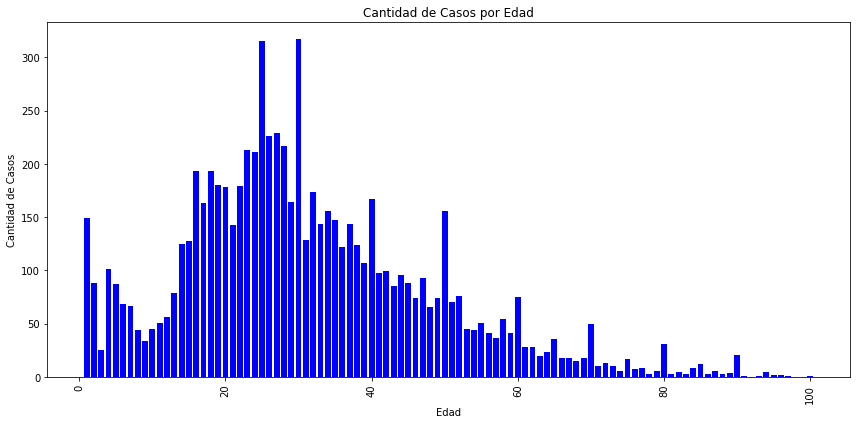

In [7]:
#Calcular el recuento de casos por edad
age_counts = labels_df['real_age'].value_counts().sort_index()

#Crear un gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(age_counts.index, age_counts.values, color='blue')
plt.xlabel('Edad')
plt.ylabel('Cantidad de Casos')
plt.title('Cantidad de Casos por Edad')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

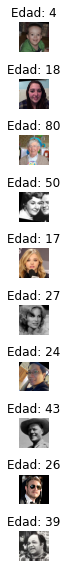

In [8]:
#Elegir algunas edades para visualizar
ages_to_display = unique_ages[:10]

#Configurar subplots
num_images_to_display = 1
num_rows = len(ages_to_display)
num_cols = num_images_to_display

plt.figure(figsize=(12, 8))

#Ciclo para mostrar imágenes por edad
for i, age in enumerate(ages_to_display):
    class_images = labels_df[labels_df['real_age'] == age]['file_name'].sample(num_images_to_display, random_state=42)
    
    for j, image_name in enumerate(class_images):
        image_path = os.path.join(data_dir, image_name)
        image = plt.imread(image_path)
        
        plt.subplot(num_rows, num_cols, i * num_images_to_display + j + 1)
        plt.imshow(image)
        plt.title(f'Edad: {age}')
        plt.axis('off')

plt.tight_layout()
plt.show()

### Conclusiones

Podemos ver que hay casos atipicos, ya que hay muchos valores altos, siendo el maximo 100, y es muy poco probable que se presenten estos casos, pues aquellos con esa edad estan limitados al movilizarse y no podrian comprar bebidas alcoholicas. Esto podria afectar el funcionamiento de nuestro modelo de Machine Learning.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

In [16]:
def load_train(path):
    #Cargar el DataFrame con las rutas de las imágenes y las etiquetas de regresión
    labels = pd.read_csv(path + 'labels.csv') 
    
    
    #Crear generador de datos para el conjunto de entrenamiento
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=90, 
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.25
    )

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=labels, 
        directory=path + 'final_files',
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=64, 
        class_mode="raw", #Para regresión
        subset= 'training', 
        seed=12345
    )
    
    return train_generator

In [17]:
def load_test(path):
    #Cargar el DataFrame con las rutas de las imágenes y las etiquetas de regresión
    labels = pd.read_csv(path + 'labels.csv') 
    
    #Crear generador de datos para el conjunto de prueba
    test_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        validation_split = 0.25
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files',
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=64,
        class_mode="raw",
        subset='validation',  #Usar el conjunto de validación
        seed=12345
    )
    
    return test_generator

In [18]:
#Función para crear el modelo ResNet-50
def create_model(input_shape, num_classes=12):
    model = Sequential()
    backbone = ResNet50(
        input_shape=input_shape, weights='imagenet', include_top=False
    )
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    
    model.add(Dropout(0.3))  
    model.add(Dense(num_classes, activation='relu'))  #Usamos num_classes en lugar de 12

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae']) 

    return model

In [19]:
#Función para entrenar el modelo 
def train_model(
    model,
    train_generator,
    test_generator,
    batch_size=None,
    epochs=11,
    steps_per_epoch=None,
    validation_steps=None,
):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_generator)
    if validation_steps is None:
        validation_steps = len(test_generator)
    
    model.fit(
        train_generator,
        validation_data=test_generator,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True,
    )

    return model

## Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [20]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = '''''

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_train(path):
    #Cargar el DataFrame con las rutas de las imágenes y las etiquetas de regresión
    labels = pd.read_csv(path + 'labels.csv') 
    
    
    #Crear generador de datos para el conjunto de entrenamiento
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=90, 
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.25
    )

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=labels, 
        directory=path + 'final_files',
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=64, 
        class_mode="raw",
        subset= 'training', #Para regresión
        seed=12345
    )
    
    return train_generator

def load_test(path):
    #Cargar el DataFrame con las rutas de las imágenes y las etiquetas de regresión
    labels = pd.read_csv(path + 'labels.csv') 
    
    #Crear generador de datos para el conjunto de prueba
    test_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        validation_split = 0.25
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files',
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=64,
        class_mode="raw",
        subset='validation',  #Usar el conjunto de validación
        seed=12345
    )
    
    return test_generator

#Función para crear el modelo ResNet-50
def create_model(input_shape, num_classes=12):
    model = Sequential()
    backbone = ResNet50(
        input_shape=input_shape, weights='imagenet', include_top=False
    )
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    
    model.add(Dropout(0.3))  
    model.add(Dense(num_classes, activation='relu'))  #Usamos num_classes en lugar de 12

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae']) 

    return model

#Función para entrenar el modelo 
def train_model(
    model,
    train_generator,
    test_generator,
    batch_size=None,
    epochs=11,
    steps_per_epoch=None,
    validation_steps=None,
):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_generator)
    if validation_steps is None:
        validation_steps = len(test_generator)
    
    model.fit(
        train_generator,
        validation_data=test_generator,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True,
    )

    return model
'''''

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### El resultado

Coloca el resultado de la plataforma GPU como una celda Markdown aquí.

2023-08-19 19:16:23.568143: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6


2023-08-19 19:16:23.569784: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6


Using TensorFlow backend.


Found 5694 validated image filenames.


Found 1897 validated image filenames.


2023-08-19 19:16:24.559124: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1


2023-08-19 19:16:24.610271: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


2023-08-19 19:16:24.610457: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0


coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s


2023-08-19 19:16:24.610489: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1


2023-08-19 19:16:24.610521: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


2023-08-19 19:16:24.612471: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10


2023-08-19 19:16:24.612795: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10


2023-08-19 19:16:24.614904: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10


2023-08-19 19:16:24.616095: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10


2023-08-19 19:16:24.616149: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


2023-08-19 19:16:24.616222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


2023-08-19 19:16:24.616459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


2023-08-19 19:16:24.616605: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0


2023-08-19 19:16:24.616916: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


2023-08-19 19:16:24.623894: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300020000 Hz


2023-08-19 19:16:24.624503: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x34020d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:


2023-08-19 19:16:24.624530: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


2023-08-19 19:16:24.711691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


2023-08-19 19:16:24.711976: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1240720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:


2023-08-19 19:16:24.711995: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0


2023-08-19 19:16:24.712241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


2023-08-19 19:16:24.712455: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s


2023-08-19 19:16:24.712504: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1


2023-08-19 19:16:24.712526: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


2023-08-19 19:16:24.712563: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10


2023-08-19 19:16:24.712583: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10


2023-08-19 19:16:24.712597: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10


2023-08-19 19:16:24.712610: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10


2023-08-19 19:16:24.712620: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


2023-08-19 19:16:24.712683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


2023-08-19 19:16:24.713007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


2023-08-19 19:16:24.713205: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0


2023-08-19 19:16:24.713250: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1


2023-08-19 19:16:24.979964: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:


2023-08-19 19:16:24.980013: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 


2023-08-19 19:16:24.980023: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 


2023-08-19 19:16:24.980232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


2023-08-19 19:16:24.980443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


2023-08-19 19:16:24.980578: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


2023-08-19 19:16:24.980610: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 14988 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:1e.0, compute capability: 7.0)


Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 1s
 5685248/94765736 [>.............................] - ETA: 0s
16195584/94765736 [====>.........................] - ETA: 0s
25616384/94765736 [=======>......................] - ETA: 0s
35676160/94765736 [==========>...................] - ETA: 0s
47144960/94765736 [=============>................] - ETA: 0s
56303616/94765736 [================>.............] - ETA: 0s
63741952/94765736 [===================>..........] - ETA: 0s
71491584/94765736 [=====================>........] - ETA: 0s
79323136/94765736 [========================>.....] - ETA: 0s
88023040/94765736 [==========================>...] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step


<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 89 steps, validate for 30 steps


Epoch 1/11


2023-08-19 19:16:36.759661: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


2023-08-19 19:16:37.654862: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


89/89 - 103s - loss: 18.7876 - mae: 18.7839 - val_loss: 27.9085 - val_mae: 27.9215


Epoch 2/11
89/89 - 95s - loss: 9.5848 - mae: 9.5851 - val_loss: 27.7490 - val_mae: 27.7619


Epoch 3/11
89/89 - 95s - loss: 8.4762 - mae: 8.4765 - val_loss: 27.9051 - val_mae: 27.9182


Epoch 4/11
89/89 - 95s - loss: 8.0860 - mae: 8.0862 - val_loss: 27.3465 - val_mae: 27.3602


Epoch 5/11
89/89 - 95s - loss: 7.6792 - mae: 7.6791 - val_loss: 26.0448 - val_mae: 26.0544


Epoch 6/11
89/89 - 95s - loss: 7.3694 - mae: 7.3696 - val_loss: 17.0180 - val_mae: 16.9955


Epoch 7/11
89/89 - 95s - loss: 7.1182 - mae: 7.1182 - val_loss: 15.1730 - val_mae: 15.1751


Epoch 8/11
89/89 - 95s - loss: 6.9618 - mae: 6.9621 - val_loss: 9.5186 - val_mae: 9.5225


Epoch 9/11
89/89 - 95s - loss: 6.7440 - mae: 6.7441 - val_loss: 8.5368 - val_mae: 8.5526


Epoch 10/11
89/89 - 95s - loss: 6.5766 - mae: 6.5766 - val_loss: 8.4566 - val_mae: 8.4758


Epoch 11/11
89/89 - 94s - loss: 6.2614 - mae: 6.2615 - val_loss: 7.5450 - val_mae: 7.5471


WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
30/30 - 10s - loss: 7.5450 - mae: 7.5471
Test MAE: 7.5471

## Conclusiones

En resumen, el modelo desarrollado para verificar la edad de las personas y cumplir con las regulaciones de venta de alcohol a menores de edad en las tiendas de Good Seed ha arrojado resultados altamente prometedores y efectivos.

Tras analizar detenidamente los resultados obtenidos, se observa que el valor del Error Absoluto Medio (MAE) en el conjunto de entrenamiento fue calculado en 6.2615, mientras que en el conjunto de pruebas se obtuvo un valor de 7.5471. Estos resultados reflejan la diferencia promedio entre las edades reales de las personas y las edades que el modelo predice. La similitud entre el MAE en el conjunto de pruebas y el conjunto de entrenamiento sugiere que el modelo ha logrado generalizar de manera adecuada a datos que no había encontrado previamente, lo cual constituye un indicador positivo.

Basándonos en estos análisis y conclusiones, es posible afirmar que el modelo ha alcanzado su objetivo de manera exitosa, logrando determinar de manera efectiva si las personas pueden adquirir alcohol en función de su edad

# Lista de control

- [x]  El Notebook estaba abierto 
- [x]  El código no tiene errores
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución
- [x]  Se realizó el análisis exploratorio de datos 
- [x]  Los resultados del análisis exploratorio de datos se presentan en el notebook final 
- [x]  El valor EAM del modelo no es superior a 8 
- [x]  El código de entrenamiento del modelo se copió en el notebook final 
- [x]  El resultado de entrenamiento del modelo se copió en el notebook final 
- [x] Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo